# Introduction

This analysis aims to provide personalized movie recommendations to users on a streaming platform based on their movie preferences and rating history. In the highly competitive streaming industry, offering relevant and tailored content is essential to increasing user engagement and reducing churn. By leveraging the MovieLens dataset from the GroupLens research lab at the University of Minnesota, this project seeks to create a recommendation system that enhances the user experience and drives long-term engagement.

## Business Problem

A streaming service is looking to improve user satisfaction and engagement by offering personalized movie recommendations. Despite having a large library of content, many users are not engaging with the platform as expected, resulting in lower average watch times and higher churn rates. The company wants to develop a movie recommendation system that can provide users with a tailored list of movies based on their past ratings and viewing history, increasing the likelihood of engagement and retention.

### Objectives

**Main Objective:** Build a recommendation system that provides the top 5 movie recommendations to each user based on their ratings of other movies. The model will be built using collaborative filtering techniques and enhanced by a hybrid approach to mitigate the cold-start problem for new users.

**Increase User Engagement**: Offer personalized recommendations that match individual preferences, encouraging users to explore more content on the platform, leading to increased average watch time.

**Improve Retention**: By consistently offering relevant recommendations, the system will help reduce user churn and foster long-term platform loyalty.

**Personalize Content Discovery**: Enable users to discover content that aligns with their unique tastes, ensuring they feel more connected to the platform and its offerings.

**Cold-Start Problem Mitigation**: For new users who haven’t rated or interacted with many movies, implement a hybrid recommendation approach that combines collaborative filtering with content-based filtering to make relevant suggestions early in their platform experience

In [80]:
# import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from surprise import Dataset, Reader, SVD, KNNBasic,NMF,KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy
import multiprocessing

In [81]:
# read data
link = pd.read_csv('data/links.csv')
link

movieId   imdbId    tmdbId
0           1   114709     862.0
1           2   113497    8844.0
2           3   113228   15602.0
3           4   114885   31357.0
4           5   113041   11862.0
...       ...      ...       ...
9737   193581  5476944  432131.0
9738   193583  5914996  445030.0
9739   193585  6397426  479308.0
9740   193587  8391976  483455.0
9741   193609   101726   37891.0

[9742 rows x 3 columns]

In [82]:
link.isna().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

There are no missing values 

In [83]:
movies = pd.read_csv('data/movies.csv')
movies

movieId                                      title  \
0           1                           Toy Story (1995)   
1           2                             Jumanji (1995)   
2           3                    Grumpier Old Men (1995)   
3           4                   Waiting to Exhale (1995)   
4           5         Father of the Bride Part II (1995)   
...       ...                                        ...   
9737   193581  Black Butler: Book of the Atlantic (2017)   
9738   193583               No Game No Life: Zero (2017)   
9739   193585                               Flint (2017)   
9740   193587        Bungo Stray Dogs: Dead Apple (2018)   
9741   193609        Andrew Dice Clay: Dice Rules (1991)   

                                           genres  
0     Adventure|Animation|Children|Comedy|Fantasy  
1                      Adventure|Children|Fantasy  
2                                  Comedy|Romance  
3                            Comedy|Drama|Romance  
4                                          Comedy  
...                                           ...  
9737              Action|Animation|Comedy|Fantasy  
9738                     Animation|Comedy|Fantasy  
9739                                        Drama  
9740                             Action|Animation  
9741                                       Comedy  

[9742 rows x 3 columns]

In [84]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [85]:
ratings = pd.read_csv('data/ratings.csv')
ratings

userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]

In [86]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [87]:
tags = pd.read_csv('data/tags.csv')
tags.head()

userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200

In [88]:
tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [89]:
tags

userId  movieId               tag   timestamp
0          2    60756             funny  1445714994
1          2    60756   Highly quotable  1445714996
2          2    60756      will ferrell  1445714992
3          2    89774      Boxing story  1445715207
4          2    89774               MMA  1445715200
...      ...      ...               ...         ...
3678     606     7382         for katie  1171234019
3679     606     7936           austere  1173392334
3680     610     3265            gun fu  1493843984
3681     610     3265  heroic bloodshed  1493843978
3682     610   168248  Heroic Bloodshed  1493844270

[3683 rows x 4 columns]

In [90]:
# Combine the datasets
movie_ratings = pd.merge(ratings, movies, on='movieId', how='left')
movie_ratings

userId  movieId  rating   timestamp                           title  \
0            1        1     4.0   964982703                Toy Story (1995)   
1            1        3     4.0   964981247         Grumpier Old Men (1995)   
2            1        6     4.0   964982224                     Heat (1995)   
3            1       47     5.0   964983815     Seven (a.k.a. Se7en) (1995)   
4            1       50     5.0   964982931      Usual Suspects, The (1995)   
...        ...      ...     ...         ...                             ...   
100831     610   166534     4.0  1493848402                    Split (2017)   
100832     610   168248     5.0  1493850091   John Wick: Chapter Two (2017)   
100833     610   168250     5.0  1494273047                  Get Out (2017)   
100834     610   168252     5.0  1493846352                    Logan (2017)   
100835     610   170875     3.0  1493846415  The Fate of the Furious (2017)   

                                             genres  
0       Adventure|Animation|Children|Comedy|Fantasy  
1                                    Comedy|Romance  
2                             Action|Crime|Thriller  
3                                  Mystery|Thriller  
4                            Crime|Mystery|Thriller  
...                                             ...  
100831                        Drama|Horror|Thriller  
100832                        Action|Crime|Thriller  
100833                                       Horror  
100834                                Action|Sci-Fi  
100835                  Action|Crime|Drama|Thriller  

[100836 rows x 6 columns]

In [91]:
movie_ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [92]:
merged_df = pd.merge(movie_ratings, tags, on='movieId', how='inner')
merged_df

userId_x  movieId  rating  timestamp_x  \
0              1        1     4.0    964982703   
1              1        1     4.0    964982703   
2              1        1     4.0    964982703   
3              5        1     4.0    847434962   
4              5        1     4.0    847434962   
...          ...      ...     ...          ...   
233208       599   176419     3.5   1516604655   
233209       599   176419     3.5   1516604655   
233210       594     7023     4.5   1108972356   
233211       606     6107     4.0   1171324428   
233212       606     6516     3.5   1171755910   

                                                    title  \
0                                        Toy Story (1995)   
1                                        Toy Story (1995)   
2                                        Toy Story (1995)   
3                                        Toy Story (1995)   
4                                        Toy Story (1995)   
...                                                   ...   
233208                                     Mother! (2017)   
233209                                     Mother! (2017)   
233210               Wedding Banquet, The (Xi yan) (1993)   
233211  Night of the Shooting Stars (Notte di San Lore...   
233212                                   Anastasia (1956)   

                                             genres  userId_y  \
0       Adventure|Animation|Children|Comedy|Fantasy       336   
1       Adventure|Animation|Children|Comedy|Fantasy       474   
2       Adventure|Animation|Children|Comedy|Fantasy       567   
3       Adventure|Animation|Children|Comedy|Fantasy       336   
4       Adventure|Animation|Children|Comedy|Fantasy       474   
...                                             ...       ...   
233208                Drama|Horror|Mystery|Thriller       567   
233209                Drama|Horror|Mystery|Thriller       567   
233210                         Comedy|Drama|Romance       474   
233211                                    Drama|War       606   
233212                                        Drama       474   

                     tag  timestamp_y  
0                  pixar   1139045764  
1                  pixar   1137206825  
2                    fun   1525286013  
3                  pixar   1139045764  
4                  pixar   1137206825  
...                  ...          ...  
233208     uncomfortable   1525287588  
233209        unsettling   1525287586  
233210  In Netflix queue   1137179697  
233211      World War II   1178473747  
233212  In Netflix queue   1137202127  

[233213 rows x 9 columns]

In [93]:
merged_df.isna().sum()

userId_x       0
movieId        0
rating         0
timestamp_x    0
title          0
genres         0
userId_y       0
tag            0
timestamp_y    0
dtype: int64

There are no missing values in the entire dataset 

In [94]:
# drop userId_y and timestamp_y 
merged_df = merged_df.drop(columns=['timestamp_y', 'userId_y', 'timestamp_x'])


In [95]:
# rename userId_x
merged_df = merged_df.rename(columns={'userId_x' : 'userId'})

In [96]:
merged_df.isna().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
tag        0
dtype: int64

In [97]:
merged_df.head()

userId  movieId  rating             title  \
0       1        1     4.0  Toy Story (1995)   
1       1        1     4.0  Toy Story (1995)   
2       1        1     4.0  Toy Story (1995)   
3       5        1     4.0  Toy Story (1995)   
4       5        1     4.0  Toy Story (1995)   

                                        genres    tag  
0  Adventure|Animation|Children|Comedy|Fantasy  pixar  
1  Adventure|Animation|Children|Comedy|Fantasy  pixar  
2  Adventure|Animation|Children|Comedy|Fantasy    fun  
3  Adventure|Animation|Children|Comedy|Fantasy  pixar  
4  Adventure|Animation|Children|Comedy|Fantasy  pixar

In [98]:
#checking duplicates 
merged_df.duplicated().value_counts()

False    219406
True      13807
dtype: int64

We can see that there are `13,807` duplicated rows, hence we drop them 

In [99]:
# dropping duplicates
merged_df = merged_df.drop_duplicates()

# confrming if there are still any duplicates 
merged_df.duplicated().value_counts()

False    219406
dtype: int64

Since our data has no dupliactes and null values we proceed to EDA

## EDA
1. Univariate Analysis
2. Bivariate Analysis

### 1. Univariate Analysis

#### 1.1 Rating

In [100]:
# RATING
merged_df.rating.value_counts()

4.0    60933
5.0    59645
4.5    29403
3.0    27246
3.5    21600
2.0     7567
2.5     6157
1.0     3553
0.5     1822
1.5     1480
Name: rating, dtype: int64

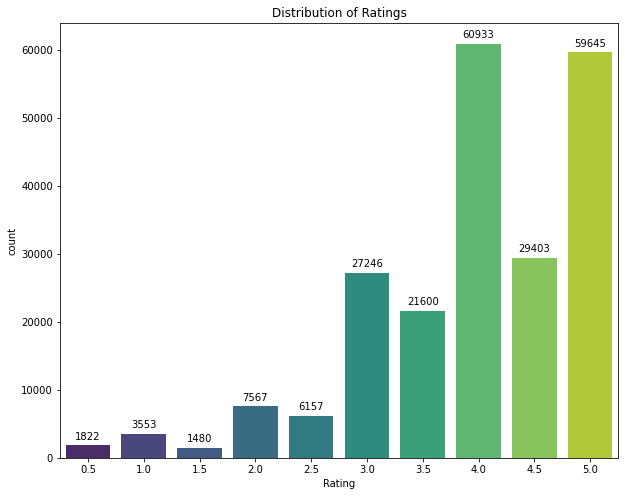

In [101]:
# bar chart 
fig, ax = plt.subplots(figsize=(10,8))

#x
x = merged_df.rating.value_counts().index
#y
y = merged_df.rating.value_counts().values


sns.barplot(x=x,y=y, ax=ax, palette='viridis')
ax.set_xlabel('Rating')
ax.set_ylabel('count')
ax.set_title('Distribution of Ratings');

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

- **4.0**(64781) and **5.0**(63845) are the most ferequent ratings

#### 1.2 Tags

In [102]:
merged_df['tag'].value_counts()

sci-fi               1891
atmospheric          1888
twist ending         1821
thought-provoking    1743
suspense             1588
                     ... 
lions                   1
Hearst                  1
nightmare               1
Suspenseful             1
parenthood              1
Name: tag, Length: 1584, dtype: int64

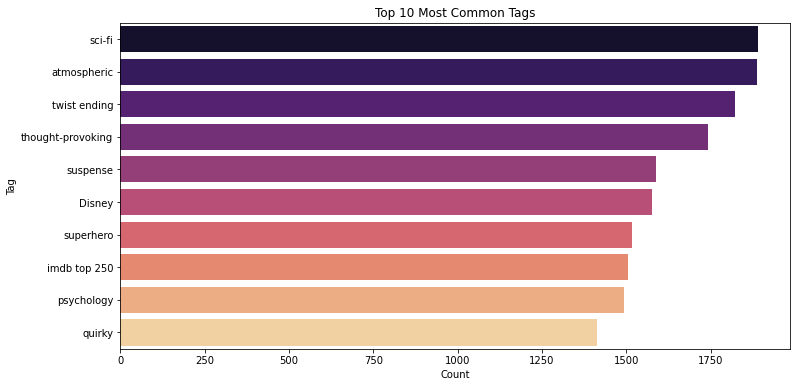

In [103]:
# Number of occurrences for each tag
tag_counts = merged_df['tag'].value_counts()

# Plot the top 10 most common tags
top_10_tags = tag_counts.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_tags.values, y=top_10_tags.index, palette='magma')
plt.title("Top 10 Most Common Tags")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.show()


**Sci-fi**, **thought-provoking** and **twist ending** are the most common movie tags

#### 1.3 Genres

In [104]:
merged_df['genres'].value_counts()

Comedy|Crime|Drama|Thriller                54395
Action|Crime|Drama|Thriller                15018
Action|Adventure|Sci-Fi                     9785
Drama                                       6159
Comedy                                      5212
                                           ...  
Drama|Thriller|Western                         1
Action|Animation|Comedy|Horror|Thriller        1
Adventure|Crime|Drama|Thriller                 1
Animation|Drama|Romance|Sci-Fi                 1
Drama|Film-Noir|Mystery                        1
Name: genres, Length: 370, dtype: int64

In [105]:
# Split genres and explode them into individual rows
merged_df['genres'] = merged_df['genres'].str.split('|')
genre_expl = merged_df.explode('genres')

# Count the occurrences of each genre
genre_counts = genre_expl['genres'].value_counts().head(10)

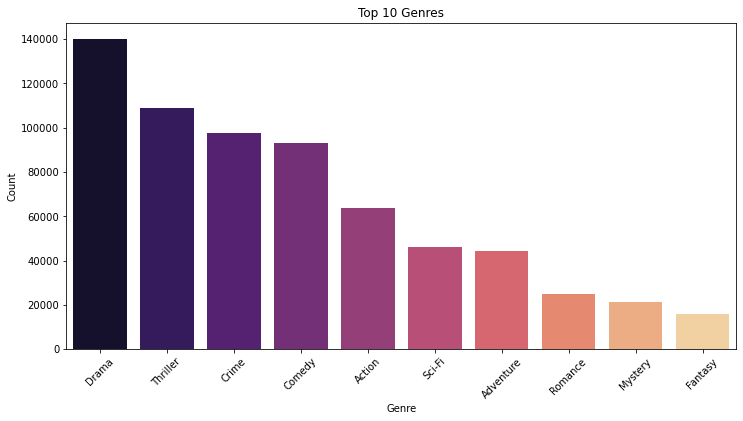

In [106]:
# Plot the top 10 genres
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='magma')
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

**Drama**(148389) is the top genre.

### 2. Bivariate Analysis

#### 2.1 User id vs Rating

In [107]:
user_ratings = merged_df[['userId', 'title','rating']].drop_duplicates()

Text(0, 0.5, 'Ratings')

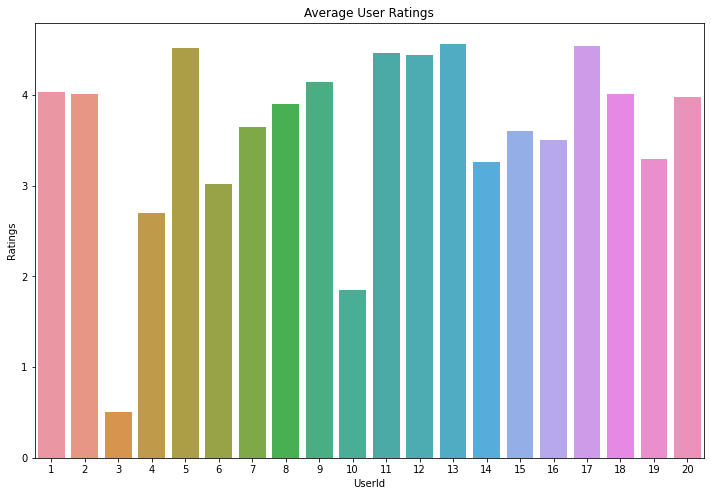

In [108]:
user_ratings = merged_df.groupby('userId').agg({
    'rating':'mean'
}).reset_index()


# plot top 20 user ratings
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x= 'userId', y='rating', data = user_ratings[:20])
plt.title('Average User Ratings')
plt.xlabel('UserId')
plt.ylabel('Ratings')

 #### 2.2 Number of ratings per user

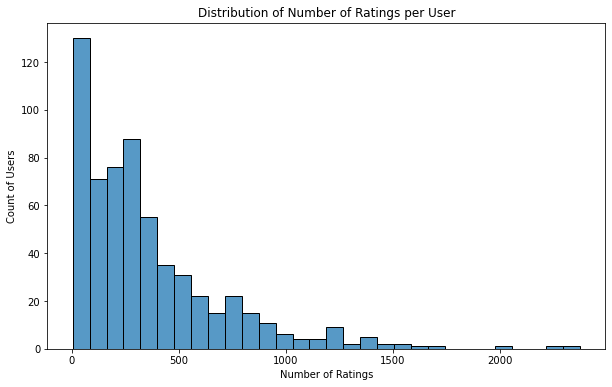

In [109]:
# Number of ratings per user
ratings_per_user = merged_df.groupby('userId')['rating'].count().sort_values(ascending=False)

# Plot the distribution of ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, kde=False, bins=30)
plt.title("Distribution of Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Count of Users")
plt.show();

#### 2.3 Number of ratings per movie

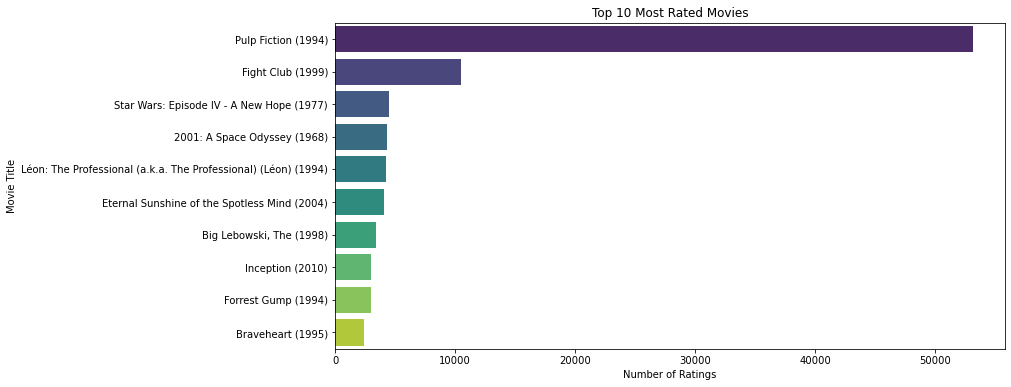

In [110]:
# Number of ratings per movie
ratings_per_movie = merged_df.groupby('title')['rating'].count().sort_values(ascending=False)

# Plot the top 10 most rated movies
top_10_movies = ratings_per_movie.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_movies.values, y=top_10_movies.index, palette='viridis')
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.show()


**PulpFiction** is the most rated movie

#### 2.4 Highest rated Movies

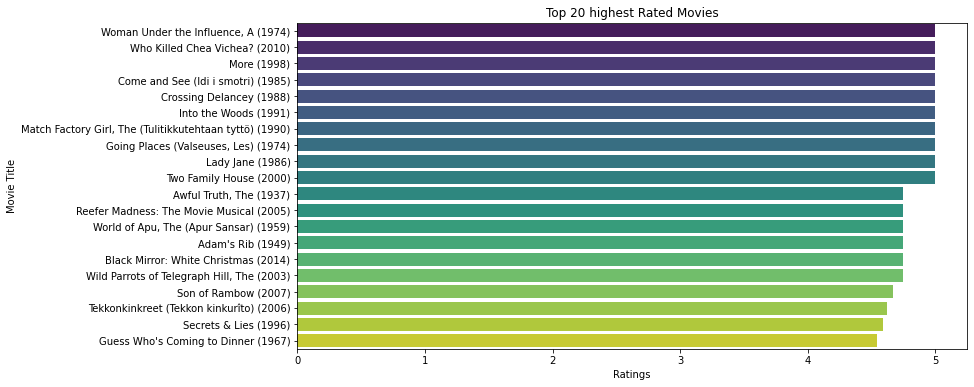

In [111]:
top_rated_movies = merged_df.groupby('title')['rating'].mean().sort_values(ascending=False)
top_rated_movies[:20]

# Plot the top 10 most rated movies
top_20_rated_movies = top_rated_movies[:20]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_rated_movies.values, y=top_20_rated_movies.index, palette='viridis')
plt.title("Top 20 highest Rated Movies")
plt.xlabel("Ratings")
plt.ylabel("Movie Title")
plt.show()

#### 2.5 Ratings by Genre

In [112]:
genre = merged_df
genre

userId  movieId  rating  \
0            1        1     4.0   
2            1        1     4.0   
3            5        1     4.0   
5            5        1     4.0   
6            7        1     4.5   
...        ...      ...     ...   
233208     599   176419     3.5   
233209     599   176419     3.5   
233210     594     7023     4.5   
233211     606     6107     4.0   
233212     606     6516     3.5   

                                                    title  \
0                                        Toy Story (1995)   
2                                        Toy Story (1995)   
3                                        Toy Story (1995)   
5                                        Toy Story (1995)   
6                                        Toy Story (1995)   
...                                                   ...   
233208                                     Mother! (2017)   
233209                                     Mother! (2017)   
233210               Wedding Banquet, The (Xi yan) (1993)   
233211  Night of the Shooting Stars (Notte di San Lore...   
233212                                   Anastasia (1956)   

                                                   genres               tag  
0       [Adventure, Animation, Children, Comedy, Fantasy]             pixar  
2       [Adventure, Animation, Children, Comedy, Fantasy]               fun  
3       [Adventure, Animation, Children, Comedy, Fantasy]             pixar  
5       [Adventure, Animation, Children, Comedy, Fantasy]               fun  
6       [Adventure, Animation, Children, Comedy, Fantasy]             pixar  
...                                                   ...               ...  
233208                 [Drama, Horror, Mystery, Thriller]     uncomfortable  
233209                 [Drama, Horror, Mystery, Thriller]        unsettling  
233210                           [Comedy, Drama, Romance]  In Netflix queue  
233211                                       [Drama, War]      World War II  
233212                                            [Drama]  In Netflix queue  

[219406 rows x 6 columns]

In [113]:
genre['genres'] = genre['genres'].str.split('|')
genre['genres']

0        NaN
2        NaN
3        NaN
5        NaN
6        NaN
          ..
233208   NaN
233209   NaN
233210   NaN
233211   NaN
233212   NaN
Name: genres, Length: 219406, dtype: float64

In [114]:
genres_exploded = genre.explode('genres')
genres_exploded

userId  movieId  rating  \
0            1        1     4.0   
2            1        1     4.0   
3            5        1     4.0   
5            5        1     4.0   
6            7        1     4.5   
...        ...      ...     ...   
233208     599   176419     3.5   
233209     599   176419     3.5   
233210     594     7023     4.5   
233211     606     6107     4.0   
233212     606     6516     3.5   

                                                    title  genres  \
0                                        Toy Story (1995)     NaN   
2                                        Toy Story (1995)     NaN   
3                                        Toy Story (1995)     NaN   
5                                        Toy Story (1995)     NaN   
6                                        Toy Story (1995)     NaN   
...                                                   ...     ...   
233208                                     Mother! (2017)     NaN   
233209                                     Mother! (2017)     NaN   
233210               Wedding Banquet, The (Xi yan) (1993)     NaN   
233211  Night of the Shooting Stars (Notte di San Lore...     NaN   
233212                                   Anastasia (1956)     NaN   

                     tag  
0                  pixar  
2                    fun  
3                  pixar  
5                    fun  
6                  pixar  
...                  ...  
233208     uncomfortable  
233209        unsettling  
233210  In Netflix queue  
233211      World War II  
233212  In Netflix queue  

[219406 rows x 6 columns]

In [115]:
genres_exploded['genres'].value_counts()

Series([], Name: genres, dtype: int64)

In [116]:
# Average rating per genre
avg_rating_per_genre = genres_exploded.groupby('genres')['rating'].mean().sort_values(ascending=False)
avg_rating_per_genre

Series([], Name: rating, dtype: float64)

In [117]:
# Plot the average rating per genre
#plt.figure(figsize=(12, 6))
#sns.barplot(x=avg_rating_per_genre.values[1:], y=avg_rating_per_genre.index[1:], palette='coolwarm')
#plt.title("Average Rating per Genre")
#plt.xlabel("Average Rating")
#plt.ylabel("Genre")
#plt.show()
avg_rating_per_genre = avg_rating_per_genre.dropna()
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating_per_genre.values, y=avg_rating_per_genre.index, palette='coolwarm')
plt.title("Average Rating per Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


ValueError: min() arg is an empty sequence

<Figure size 864x432 with 0 Axes>

**Crime**  |  **War** | **Thriller** | **Drama** | **Film-Noir**  - are the top rated genres, with an average of **4.0+**     

## Modelling 

### Colaborative filtering 
Collaborative filtering is a recommendation technique that personalizes suggestions based on the preferences of similar users, relying on the principle that past agreements predict future preferences. It effectively leverages user-item interactions without needing detailed item features, making it suitable for domains like movies or music. By calculating similarities among users or items from historical ratings, collaborative filtering uncovers hidden patterns, providing diverse and relevant recommendations that enhance user satisfaction. This approach is applied in the project to deliver personalized movie recommendations tailored to individual user preferences.

# Baseline model 
## Using SVD

In [40]:
# Define a Reader object to specify the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the DataFrame
data = Dataset.load_from_df(merged_df[['userId', 'title', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Build the SVD model
model = SVD(random_state=42)

# Train the model on the training set
model.fit(trainset)

# Test the model on the test set
predictions = model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Recommend top N movies for a specific user
def get_top_n_recommendations(predictions, user_id, n=10):
    # Sort the predictions for the specified user and get the top n movies
    user_predictions = [(pred.iid, pred.est) for pred in predictions if pred.uid == user_id]
    user_predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = user_predictions[:n]
    return top_n


RMSE: 0.4180
MAE:  0.2772


`RMSE (Root Mean Squared Error): 0.4180`

- This indicates the average deviation between the predicted and actual ratings is approximately `0.42` on a scale of 1 to 5. A lower RMSE suggests that the NMF model is providing accurate predictions, with only minor errors.

`MAE (Mean Absolute Error): 0.2772`

- This reflects the average absolute difference between the predicted and actual ratings, which is about `0.27.` Since MAE is lower than RMSE, the model's predictions are generally quite close to the actual ratings.

`Overall`, both metrics are low, suggesting that the SVD model performs well in predicting user ratings for movie recommendations with minimal errors.

In [42]:
# for example listing the recommendations for user 610
top_10_movies = get_top_n_recommendations(predictions, user_id=610, n=10)

# Print the top 10 movie recommendations vertically
print(f"Top 10 movie recommendations for user 610:")
for movie_id, rating in top_10_movies:
    print(f"Movie ID: {movie_id}, Estimated Rating: {rating:.2f}")

Top 10 movie recommendations for user 610:
Movie ID: Apocalypse Now (1979), Estimated Rating: 4.96
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94
Movie ID: Pulp Fiction (1994), Estimated Rating: 4.94


It can be seen from the example above about the model results where user `610' was used:

- `Overfitting` to Popular Movies: The model may over-prioritize popular films like `Pulp Fiction`, limiting personalized suggestions.

- `Lack of Diversity`: Repeating `Pulp Fiction` multiple times shows poor diversity, reducing the variety of recommendations.

- `Similarity Calculation Bias`: Collaborative filtering favors widely liked movies, leading to biased predictions based on similar users.

- `Limited Novelty`: The model struggles to provide new, varied suggestions, focusing too much on well-known films.

## Model 2 using NMF

In [41]:

# Define a Reader object to specify the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the DataFrame
data = Dataset.load_from_df(merged_df[['userId', 'title', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Build the NMF model
model = NMF(random_state=42)

# Train the model on the training set
model.fit(trainset)

# Test the model on the test set
predictions = model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Recommend top N movies for a specific user
def get_top_n_recommendations(predictions, user_id, n=10):
    # Sort the predictions for the specified user and get the top n movies
    user_predictions = [(pred.iid, pred.est) for pred in predictions if pred.uid == user_id]
    user_predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = user_predictions[:n]
    return top_n


RMSE: 0.6159
MAE:  0.4236


`RMSE (Root Mean Squared Error): 0.6159`

- This means that the KNN with Means model's predicted ratings are, on average, `0.62` away from the actual ratings on a 1-5 scale. Compared to models like SVD or NMF, this is a higher RMSE, suggesting that KNN with Means is less effective at predicting ratings with precision in this dataset.

`MAE (Mean Absolute Error): 0.4236`

- The average absolute difference between the predicted and actual ratings is `0.42`. While MAE is lower than RMSE, it still indicates a notable error in the model's predictions, showing that NMF more accurate compared to other models like SVD, which had lower error metrics.

# KNNwithMeans

In [41]:
# Define a Reader object to specify the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset from the DataFrame
data = Dataset.load_from_df(merged_df[['userId', 'title', 'rating']], reader)

# Split the data into train and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Use the KNNWithMeans algorithm
sim_options = {
    'name': 'cosine',  # Use cosine similarity
    'user_based': True  # User-based collaborative filtering
}

model = KNNWithMeans(sim_options=sim_options)

# Train the model on the training set
model.fit(trainset)

# Test the model on the test set
predictions = model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

# Recommend top N movies for a specific user
def get_top_n_recommendations(predictions, user_id, n=10):
    # Sort the predictions for the specified user and get the top n movies
    user_predictions = [(pred.iid, pred.est) for pred in predictions if pred.uid == user_id]
    user_predictions.sort(key=lambda x: x[1], reverse=True)
    top_n = user_predictions[:n]
    return top_n




Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.6354
MAE:  0.4300


`RMSE (0.6382):`

- Indicates moderate prediction error; suggests room for improvement in model accuracy.

`MAE (0.4320):`

- Reflects an average prediction error of about 0.43 points, indicating moderate accuracy but potential discrepancies for users.

Hence, KNNwithMeans has prrofed to be best model than SVD and NMF.

In [42]:
# Example usage to get top 10 movie recommendations for user with ID 1
user_id = 1
top_n = get_top_n_recommendations(predictions, user_id, n=10)

# Print the top N recommendations
for movie_id, rating in top_n:
    print(f"Movie: {movie_id}, Predicted Rating: {rating}")

Movie: Big Lebowski, The (1998), Predicted Rating: 4.847195270833624
Movie: Big Lebowski, The (1998), Predicted Rating: 4.847195270833624
Movie: Big Lebowski, The (1998), Predicted Rating: 4.847195270833624
Movie: Big Lebowski, The (1998), Predicted Rating: 4.847195270833624
Movie: Big Lebowski, The (1998), Predicted Rating: 4.847195270833624
Movie: Big Lebowski, The (1998), Predicted Rating: 4.847195270833624
Movie: Usual Suspects, The (1995), Predicted Rating: 4.835774035010674
Movie: Fight Club (1999), Predicted Rating: 4.822304903361197
Movie: Fight Club (1999), Predicted Rating: 4.822304903361197
Movie: Fight Club (1999), Predicted Rating: 4.822304903361197


# Conclusion
- KNN with Means struggles with overfitting on popular movies, leading to repetitive recommendations and moderate prediction accuracy.
- NMF performs better than KNN but still has issues with prioritizing popular films, resulting in moderate prediction errors.
- SVD provides the most accurate predictions with low RMSE (0.4180) and MAE (0.2772), offering minimal errors.
- SVD balances personalized recommendations and accuracy, avoiding overfitting and delivering diverse suggestions.
- SVD is the recommended model due to its superior performance in predicting user ratings and offering varied, reliable recommendations.

# Recommendations 
- Adopt SVD as the Primary Model: Utilize the SVD model for generating movie recommendations due to its superior accuracy and ability to provide diverse suggestions, minimizing the risk of overfitting to popular films.

- Incorporate Hybrid Approaches: Consider combining SVD with other models like KNN or NMF to leverage their strengths, potentially improving overall recommendation quality and providing a more balanced user experience.

- Enhance Personalization Features: Improve user experience by incorporating user preferences and feedback into the models, allowing for more tailored recommendations that align with individual tastes.

- Regularly Update Models: Continuously retrain and update the recommendation models with new data to adapt to changing user preferences and emerging trends in movie ratings, ensuring the recommendations remain relevant and accurate.